In [184]:
import pandas as pd
import numpy as np
import os
import json
import pygeohash as pgh
import folium
from folium.plugins import HeatMap
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import geopandas as gdf
from shapely.geometry import Polygon
import seaborn as sns
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

In [185]:
os.chdir("D:/UofT/STA2453/Project 2/Data/Cleaned Data")

In [186]:
#Reading Geo Tab Data
geoTabDat=pd.read_csv("SearchingForParking_Toronto.csv")

In [187]:
#Columns in Geo Tab data
geoTabDat.columns

Index(['Geohash', 'Latitude_SW', 'Longitude_SW', 'Latitude_NE', 'Longitude_NE',
       'Latitude', 'Longitude', 'City', 'County', 'State', 'Country',
       'ISO_3166_2', 'AvgTimeToPark', 'AvgTimeToParkRatio', 'TotalSearching',
       'PercentSearching', 'AvgUniqueGeohashes', 'AvgTotalGeohashes',
       'CirclingDistribution', 'HourlyDistribution', 'SearchingByHour',
       'PercentCar', 'PercentMPV', 'PercentLDT', 'PercentMDT', 'PercentHDT',
       'PercentOther', 'UpdateDate', 'Version'],
      dtype='object')

In [188]:
#Subsetting only for Circling Distribution Exploration
geoTabCircleDat=geoTabDat[['Geohash','AvgTimeToPark','PercentSearching','CirclingDistribution']][geoTabDat['City']=='Toronto']

In [189]:
#Convert JSON string to dictionary
CirclingDistListDict = geoTabCircleDat.CirclingDistribution.apply(json.loads).values.tolist() 

In [190]:
#Create dataframe of Circling distribution
geoCircleDict={"parkGeoHash":[],"spendGeoHash":[],"pctTimeSpend":[],"AvgTimeToPark":[],"PercentSearching":[]}
i=0
for geoCircle in CirclingDistListDict:
    geoCircleDict["parkGeoHash"].extend([geoTabCircleDat["Geohash"][i]]*len(geoCircle.keys()))
    geoCircleDict["spendGeoHash"].extend(list(geoCircle.keys()))
    geoCircleDict["pctTimeSpend"].extend(list(geoCircle.values()))
    geoCircleDict["AvgTimeToPark"].extend([geoTabCircleDat["AvgTimeToPark"][i]]*len(geoCircle.keys()))
    geoCircleDict["PercentSearching"].extend([geoTabCircleDat["PercentSearching"][i]]*len(geoCircle.keys()))
    i+=1
geoCircleDat=pd.DataFrame(geoCircleDict)

# Exploratory Data Analysis:

### 1. What's the average time spent in parking in a neighborhood geohash for a vehicle?

In [191]:
#This table shows us, how many different park neighborhoods does a vehicle spending most time in a spend neighborhood can go into and the average parking time of these park geohashes
#idx = geoCircleDat.groupby(['parkGeoHash'])['pctTimeSpend'].transform(max) == geoCircleDat['pctTimeSpend']
geoCircleDatAgg=geoCircleDat.groupby(["spendGeoHash"],as_index=False).agg({'parkGeoHash':'nunique','AvgTimeToPark':'mean'})
geoCircleDatAgg=geoCircleDat.groupby(["spendGeoHash"],as_index=False).agg({'parkGeoHash':'nunique','AvgTimeToPark':'mean'})

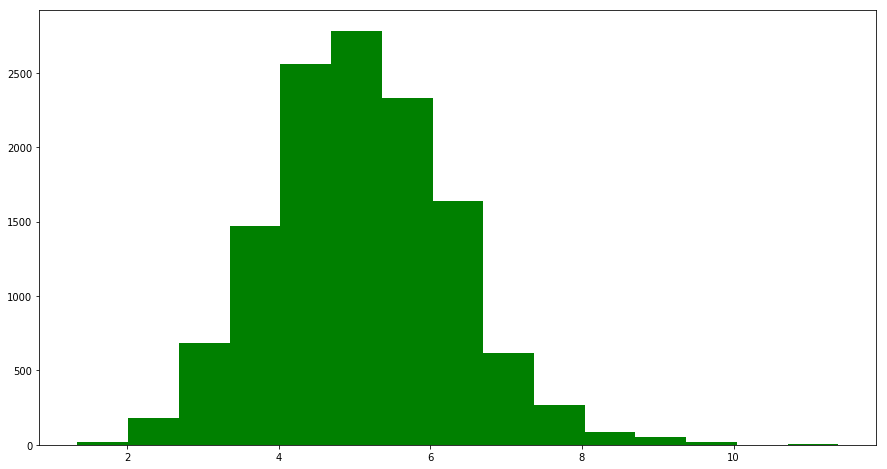

In [192]:
#Histogram of Avg. Parking time per park neighborhood
plt.figure(figsize=(15,8))
pyplot.hist(geoCircleDatAgg["AvgTimeToPark"],color="g",bins=15);

#### Most vehicles spend 4-6 mins on an average in finding a parking spot at neighbor geohashes.

### 2. What's the average number of neighorhood geohashes vehicles drive to find a parking?

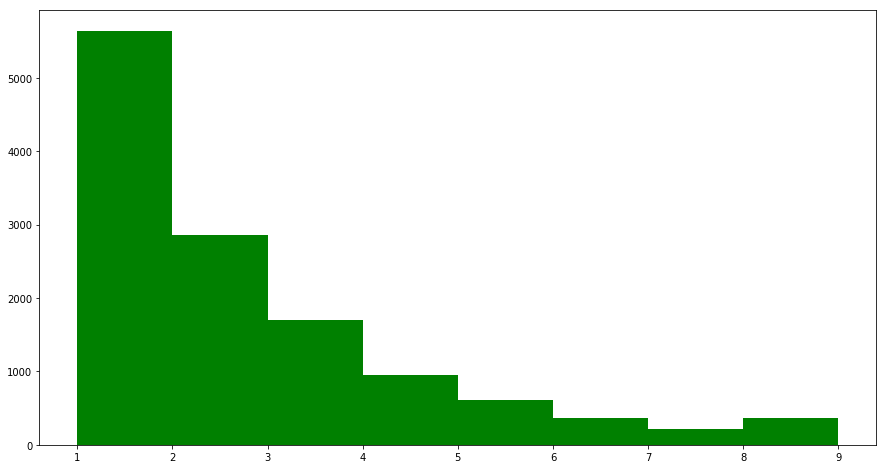

In [193]:
#Histogram of, # of different neighborhoods into which vehicles park at from a specific neighborhood 
plt.figure(figsize=(15,8))
pyplot.hist(geoCircleDatAgg["parkGeoHash"],color="g",bins=8);

#### Most vehicles find a parking spot within circling upto two different neighborhoods. However, a fewer number of locations require vehicles to circle more than five different neighborhhods

### 3. Is parking time more on neighborhoods than on own geohash?

For the purpose of this analysis, we only compare the average parking time across all different neighborhoods,vehicles at a specific geohas has driven to park and compare that against the 6 month average parking time for own geohash parking.

 Parking Index= (Avg. Neighborhood GeoHash Avg. Parking  Time)/(Avg. Current GeoHash Parking Time)
 
Note: For the purpose of the heatmap visualisation, we highlight every geohash with more than average ratio across the city.

In [194]:
geoCircleParkDatAgg=geoTabDat.groupby(["Geohash"],as_index=False).agg({'AvgTimeToPark':'mean'})
geoCircleParkDatAgg.columns=["spendGeoHash","avgTimeToPark_parkGeoHash"]

In [195]:
geoCircleDatAgg['spend_lat'] = geoCircleDatAgg.apply(lambda row: pgh.decode(row.spendGeoHash)[0], axis = 1)
geoCircleDatAgg['spend_lng'] = geoCircleDatAgg.apply(lambda row: pgh.decode(row.spendGeoHash)[1], axis = 1)
geoCircleDatAgg=geoCircleDatAgg.merge(geoCircleParkDatAgg,on=['spendGeoHash'])

In [199]:
geoCircleDatAgg.columns=['spendGeoHash','no_of_parkGeoHash','avgParkTime_parkGeoHash','spend_lat','spend_lng','avgTimeToPark_spendGeoHash']

In [200]:
geoCircleDatAgg.head()

,spendGeoHash,no_of_parkGeoHash,avgParkTime_parkGeoHash,spend_lat,spend_lng,avgTimeToPark_spendGeoHash
0,dpxrvzm,4,3.631550,43.59,-79.54,2.5233
1,dpxrvzs,2,4.266050,43.59,-79.55,4.1580
2,dpxrvzt,4,3.631550,43.59,-79.54,4.3741
3,dpxrvzw,4,4.185500,43.59,-79.54,3.4708
4,dpxrvzz,3,4.358967,43.59,-79.54,6.3738


In [201]:
cmprParkTimeDat=geoCircleDatAgg[geoCircleDatAgg["avgTimeToPark_spendGeoHash"].notnull()]
cmprParkTimeDat['ownToNeighParkTimeIndex']=cmprParkTimeDat['avgParkTime_parkGeoHash']/cmprParkTimeDat['avgTimeToPark_spendGeoHash']

In [202]:
cmprParkTimeDat.head()

,spendGeoHash,no_of_parkGeoHash,avgParkTime_parkGeoHash,spend_lat,spend_lng,avgTimeToPark_spendGeoHash,ownToNeighParkTimeIndex
0,dpxrvzm,4,3.631550,43.59,-79.54,2.5233,1.439207
1,dpxrvzs,2,4.266050,43.59,-79.55,4.1580,1.025986
2,dpxrvzt,4,3.631550,43.59,-79.54,4.3741,0.830239
3,dpxrvzw,4,4.185500,43.59,-79.54,3.4708,1.205918
4,dpxrvzz,3,4.358967,43.59,-79.54,6.3738,0.683888


In [203]:
cmprParkTimeDat['ownToNeighParkTimeIndex_scaled']=(cmprParkTimeDat.ownToNeighParkTimeIndex-cmprParkTimeDat.ownToNeighParkTimeIndex.mean())/cmprParkTimeDat.ownToNeighParkTimeIndex.std()

In [204]:
# Create heatmap data
geoCirclehtMpDat = cmprParkTimeDat[['spendGeoHash','avgParkTime_parkGeoHash','spend_lat','spend_lng']]
geoCirclehtMpDat['avgParkTime_parkGeoHash_scaled']=(geoCirclehtMpDat['avgParkTime_parkGeoHash']-geoCirclehtMpDat['avgParkTime_parkGeoHash'].mean())/geoCirclehtMpDat['avgParkTime_parkGeoHash'].std()
geoCirclehtMpDat['Value'] = geoCirclehtMpDat.apply(lambda row: [row.spend_lat, row.spend_lng, row.avgParkTime_parkGeoHash_scaled], axis = 1)
heatdata = geoCirclehtMpDat.Value.tolist() # a list of lists: [[latitude, longitude, avg_per_neighbrohood],...]

# Define map 
heatmap = folium.Map([45.418167,-75.690994], tiles='openstreetmap', zoom_start=6)

# Plot Geohash Markers
Markers = folium.FeatureGroup(name='Circling GeoHash Distribution')

# Plot heatmap based on the Searching for Parking Index
index = folium.FeatureGroup(name='Geohash- Avg. Per Neigh')
HeatMap(data = heatdata, min_opacity = 0.3, max_zoom = 12, max_val = 1 ,radius=15).add_to(index) 
index.add_to(heatmap)
heatmap

#### Average Parking Index Ratio:

Most neighborhoods have similar park time as own location

In [205]:
cmprParkTimeDat.ownToNeighParkTimeIndex.mean()

1.0316262099592115

In [206]:
# Define map 
heatmap = folium.Map([45.418167,-75.690994], tiles='openstreetmap', zoom_start=6)

# Create heatmap data
cmprParkTimeHtMpDat = cmprParkTimeDat[['spendGeoHash','ownToNeighParkTimeIndex_scaled','spend_lat','spend_lng']]
cmprParkTimeHtMpDat['Value'] = cmprParkTimeHtMpDat.apply(lambda row: [row.spend_lat, row.spend_lng, row.ownToNeighParkTimeIndex_scaled], axis = 1)
heatdata = cmprParkTimeHtMpDat.Value.tolist() # a list of lists: [[latitude, longitude, avg_per_neighbrohood],...]

# Plot heatmap based on the Searching for Parking Index
OwnNeighborindex = folium.FeatureGroup(name='Own Vs Neighborhood Parking Index-GeoHash Level')
HeatMap(data = heatdata, min_opacity = 0.3, max_zoom = 12, max_val = 1 ,radius=15).add_to(OwnNeighborindex) 
OwnNeighborindex.add_to(heatmap)

# Add all the layers (feature groups) onto the map
folium.LayerControl().add_to(heatmap)
heatmap

As can be seen in most neighborhoods, vehicles spend as much time parking in circling area, as they would in currnet geohash zone.

In [207]:
# Compare to see if the difference in the two parking times are statistically significant
f_value, p_value = stats.f_oneway(cmprParkTimeDat['avgParkTime_parkGeoHash'],cmprParkTimeDat['avgTimeToPark_spendGeoHash'])

In [208]:
p_value

0.8428638371750574

#### A F-Test to test for difference between the park time in own and neighborhood zones suggest that the differences if any is not statistically signifcant

In [209]:
geoCircleDat.columns=['parkGeoHash','spendGeoHash','pctTimeSpend','parkGeoHash_AvgTimeToPark','parkGeoHash_PercentSearching']

In [210]:
geoTabCircleDat=geoTabDat[['Geohash','AvgTimeToPark','PercentSearching']]

In [211]:
geoTabCircleDat.columns=['spendGeoHash','spendGeoHash_AvgTimeToPark','spendGeoHash_PercentSearching']

In [212]:
geoCircleDat=geoCircleDat.merge(geoTabCircleDat,on='spendGeoHash')

In [213]:
def find_distance(x):
    return pgh.geohash_approximate_distance(x[0],x[1])
geoCircleDat['distance']=geoCircleDat.apply(find_distance,axis=1)

In [214]:
#Decode Spend Geohash into latitude and longitude
geoCircleDat=pd.DataFrame(geoCircleDat)
geoCircleDat['spend_lat'] = geoCircleDat.apply(lambda row: pgh.decode(row.spendGeoHash)[0], axis = 1)
geoCircleDat['spend_lng'] = geoCircleDat.apply(lambda row: pgh.decode(row.spendGeoHash)[1], axis = 1)
geoCircleDat['park_lat'] = geoCircleDat.apply(lambda row: pgh.decode(row.parkGeoHash)[0], axis = 1)
geoCircleDat['park_lng'] = geoCircleDat.apply(lambda row: pgh.decode(row.parkGeoHash)[1], axis = 1)

In [215]:
geoCircleDat.head()

,parkGeoHash,spendGeoHash,pctTimeSpend,parkGeoHash_AvgTimeToPark,parkGeoHash_PercentSearching,spendGeoHash_AvgTimeToPark,spendGeoHash_PercentSearching,distance,spend_lat,spend_lng,park_lat,park_lng
0,dpz2nth,dpz2ntm,0.1646,4.2656,0.2645,4.1833,0.12,610,43.62,-79.51,43.62,-79.51
1,dpz2ntw,dpz2ntm,0.0938,4.6771,0.0500,4.1833,0.12,610,43.62,-79.51,43.62,-79.51
2,dpz2ntm,dpz2ntm,0.2230,4.1833,0.1200,4.1833,0.12,118,43.62,-79.51,43.62,-79.51
3,dpz2ntq,dpz2ntm,0.0856,4.3179,0.1327,4.1833,0.12,610,43.62,-79.51,43.62,-79.51
4,dpz2nth,dpz2nt7,0.2464,4.2656,0.2645,5.0130,0.20,610,43.62,-79.51,43.62,-79.51


In [216]:
food_shop_count=pd.read_csv("Food_Shop_GeoHash_Count.csv")

In [217]:
food_shop_count=food_shop_count[['Geohash','District','food_count','shop_count']].drop_duplicates(keep=False)

In [218]:
food_shop_count.columns=['spendGeoHash','spendDistrict','spendFoodC','spendShopC']
geoCircleDat=geoCircleDat.merge(food_shop_count,on='spendGeoHash')
food_shop_count.columns=['parkGeoHash','parkDistrict','parkFoodC','parkShopC']
geoCircleDat=geoCircleDat.merge(food_shop_count,on='parkGeoHash')
food_shop_count.columns=['Geohash','District','FoodC','ShopC']
geoTabDat=geoTabDat.merge(food_shop_count,on='Geohash')

In [219]:
geoCircleDat.head()

,parkGeoHash,spendGeoHash,pctTimeSpend,parkGeoHash_AvgTimeToPark,parkGeoHash_PercentSearching,spendGeoHash_AvgTimeToPark,spendGeoHash_PercentSearching,distance,spend_lat,spend_lng,park_lat,park_lng,spendDistrict,spendFoodC,spendShopC,parkDistrict,parkFoodC,parkShopC
0,dpz2nth,dpz2ntm,0.1646,4.2656,0.2645,4.1833,0.1200,610,43.62,-79.51,43.62,-79.51,Etobicoke,9,8,Etobicoke,2,3
1,dpz2nth,dpz2nt7,0.2464,4.2656,0.2645,5.0130,0.2000,610,43.62,-79.51,43.62,-79.51,Etobicoke,5,5,Etobicoke,2,3
2,dpz2nth,dpz2nth,0.1904,4.2656,0.2645,4.2656,0.2645,118,43.62,-79.51,43.62,-79.51,Etobicoke,2,3,Etobicoke,2,3
3,dpz2ntw,dpz2ntm,0.0938,4.6771,0.0500,4.1833,0.1200,610,43.62,-79.51,43.62,-79.51,Etobicoke,9,8,Etobicoke,15,11
4,dpz2ntw,dpz2ntq,0.0317,4.6771,0.0500,4.3179,0.1327,610,43.62,-79.51,43.62,-79.51,Etobicoke,2,12,Etobicoke,15,11


# Ranking based GeoHash Parking Suggestion:

In [220]:
def findPArkGeoHash(spendGeoHash):
    
    '''This function returns the Geohash that is best to park based on a simple ranking algorithm'''
    
    #Subset only those records relevant to spendGeoHash
    spendDat=geoTabDat
    spendDat['distance']=spendDat.apply(lambda row: pgh.geohash_approximate_distance(row.Geohash,spendGeoHash),axis=1)
    
    #Rank by distance
    spendDat['dRank']=spendDat['distance'].rank(ascending=True)
    
    #Rank by Avg. Time to Park
    spendDat['parkRank']=spendDat['AvgTimeToPark'].rank(ascending=True)
    
     #Rank by Percentage Searching for Parking
    spendDat['searchRank']=spendDat['PercentSearching'].rank(ascending=True)
    
    #Rank by Food and Shop Counts
    spendDat['foodRank']=spendDat['FoodC'].rank(ascending=True)
    
    #Rank by Food and Shop Counts
    spendDat['shopRank']=spendDat['ShopC'].rank(ascending=True)
    
    spendDat=spendDat.drop_duplicates(keep=False)
    
    spendDat['totalRank']=10*(spendDat['dRank']+spendDat['parkRank'])+5*(spendDat['searchRank'])+2.5*(spendDat['foodRank']+spendDat['shopRank'])
    
    
    #spendDat['totalRank']=spendDat['totalRank']/(4*len(spendDat['Geohash']))
    spendDat['parkGeoHash']=spendDat['Geohash']
    spendDat['spendGeoHash']=spendGeoHash
    
    #Retain only required columns
    spendDat=spendDat[['parkGeoHash','spendGeoHash','distance','AvgTimeToPark','PercentSearching','FoodC','ShopC','dRank','parkRank','searchRank','foodRank','shopRank','totalRank']].drop_duplicates(keep=False)
    
    return spendDat[spendDat['totalRank']==min(spendDat['totalRank'])]

In [221]:
#Find the best Geohash to park for each Geohash location, based on Rannking of distance, Parking Time, % vehicles searching for parking, # of food and shops
spendGeoHashes=geoCircleDat.spendGeoHash.unique()
Rank_geoCircleDat = pd.DataFrame()
for spendGeoHash in spendGeoHashes:
    Rank_geoCircleDat=Rank_geoCircleDat.append(findPArkGeoHash(spendGeoHash))
#findPArkGeoHash(spendGeoHash)

In [44]:

Rank_geoCircleDat.head()

,parkGeoHash,spendGeoHash,distance,AvgTimeToPark,PercentSearching,FoodC,ShopC,dRank,parkRank,searchRank,foodRank,shopRank,totalRank
3622,dpz2nnx,dpz2ntm,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2nt7,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2nth,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2ntq,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5
3622,dpz2nnx,dpz2ntr,3803,3.0208,0.0282,0,4,67.5,164.0,174.5,536.0,1594.0,8512.5


In [47]:
#Find the avg. park time it currently takes to find a parking spot, from each geo hash
actualParkTimeDat=geoCircleDat.groupby(by=['spendGeoHash'],as_index=False).agg({'parkGeoHash_AvgTimeToPark':'mean'})

In [57]:
#Compare the rank based recommendation with actual park time
compareActPredParkTime=actualParkTimeDat.merge(Rank_geoCircleDat[['parkGeoHash','spendGeoHash','AvgTimeToPark']],on='spendGeoHash')

In [58]:
compareActPredParkTime.columns=['spendGeoHash','Act_Avg_ParkTime','Rec_parkGeoHash','Rec_ParkTime']
compareActPredParkTime['RecnPerfIndex']=compareActPredParkTime['Rec_ParkTime']/compareActPredParkTime['Act_Avg_ParkTime']

In [59]:
compareActPredParkTime.head()

,spendGeoHash,Act_Avg_ParkTime,Rec_parkGeoHash,Rec_ParkTime,RecnPerfIndex
0,dpxrvzm,3.631550,dpxrvzm,2.5233,0.694827
1,dpxrvzs,4.266050,dpxrvzm,2.5233,0.591484
2,dpxrvzt,3.631550,dpxrvzm,2.5233,0.694827
3,dpxrvzw,4.185500,dpxrvzm,2.5233,0.602867
4,dpxrvzz,4.358967,dpxrvzm,2.5233,0.578876


C:\Users\bhara\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\bhara\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


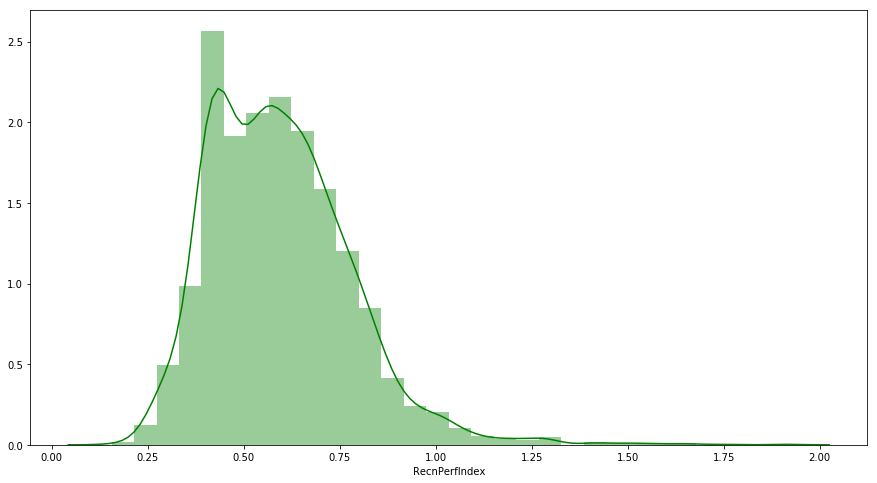

In [121]:
#Histogram of Ranking based GeoHash Park Time Vs Actual Geohash Park Time
plt.figure(figsize=(15,8))
sns.distplot(compareActPredParkTime["RecnPerfIndex"],bins=30,color="g");

Using a simple ranking algorithm of different features considered, our suggestion can lead to much reduced park time than the current scenario

In [70]:
# How does the recommended geohash compare to own geohash park time?
compareActPredParkTime=compareActPredParkTime.merge(geoTabDat[['Geohash','AvgTimeToPark']],left_on='spendGeoHash',right_on='Geohash')

In [74]:
compareActPredParkTime=compareActPredParkTime.drop(['Geohash'],axis=1)

In [76]:
compareActPredParkTime.columns=['spendGeoHash', 'Act_Avg_ParkTime', 'Rec_parkGeoHash', 'Rec_ParkTime','RecnPerfIndex', 'Own_AvgTimeToPark']

In [78]:
compareActPredParkTime['OwnRecnPerfIndex']=compareActPredParkTime['Rec_ParkTime']/compareActPredParkTime['Own_AvgTimeToPark']

C:\Users\bhara\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\bhara\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


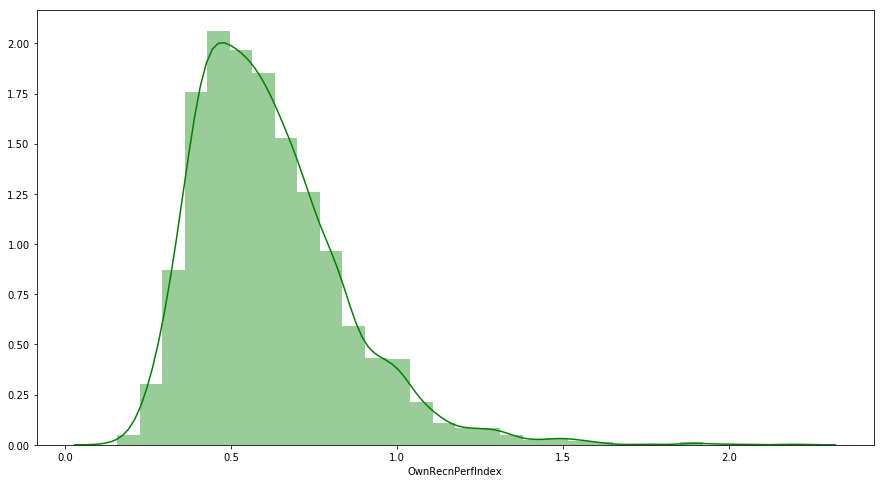

In [122]:
plt.figure(figsize=(15,8))
sns.distplot(compareActPredParkTime["OwnRecnPerfIndex"],bins=30,color="g");

In this case too, the ranking based geohash is much better than own geo hash park time